
Processing file: Control_130117.csv (Group: Control)


Processing time steps for Control_130117.csv: 100%|█████████████████████████████████| 400/400 [00:01<00:00, 278.32it/s]



Processing file: Control_140117.csv (Group: Control)


Processing time steps for Control_140117.csv: 100%|█████████████████████████████████| 400/400 [00:01<00:00, 288.88it/s]



Processing file: Control_191216.csv (Group: Control)


Processing time steps for Control_191216.csv: 100%|█████████████████████████████████| 400/400 [00:01<00:00, 287.94it/s]



Processing file: LanB1_270317.csv (Group: LanB1)


Processing time steps for LanB1_270317.csv: 100%|███████████████████████████████████| 400/400 [00:01<00:00, 255.24it/s]



Processing file: LanB1_280317A.csv (Group: LanB1)


Processing time steps for LanB1_280317A.csv: 100%|██████████████████████████████████| 400/400 [00:01<00:00, 265.22it/s]



Processing file: LanB1_280317B.csv (Group: LanB1)


Processing time steps for LanB1_280317B.csv: 100%|██████████████████████████████████| 400/400 [00:01<00:00, 257.20it/s]



Processing file: Scar_140117.csv (Group: SCAR)


Processing time steps for Scar_140117.csv: 100%|████████████████████████████████████| 400/400 [00:01<00:00, 250.66it/s]



Processing file: Scar_151216.csv (Group: SCAR)


Processing time steps for Scar_151216.csv: 100%|████████████████████████████████████| 400/400 [00:01<00:00, 267.97it/s]



Processing file: Scar_201216.csv (Group: SCAR)


Processing time steps for Scar_201216.csv: 100%|████████████████████████████████████| 400/400 [00:01<00:00, 269.40it/s]


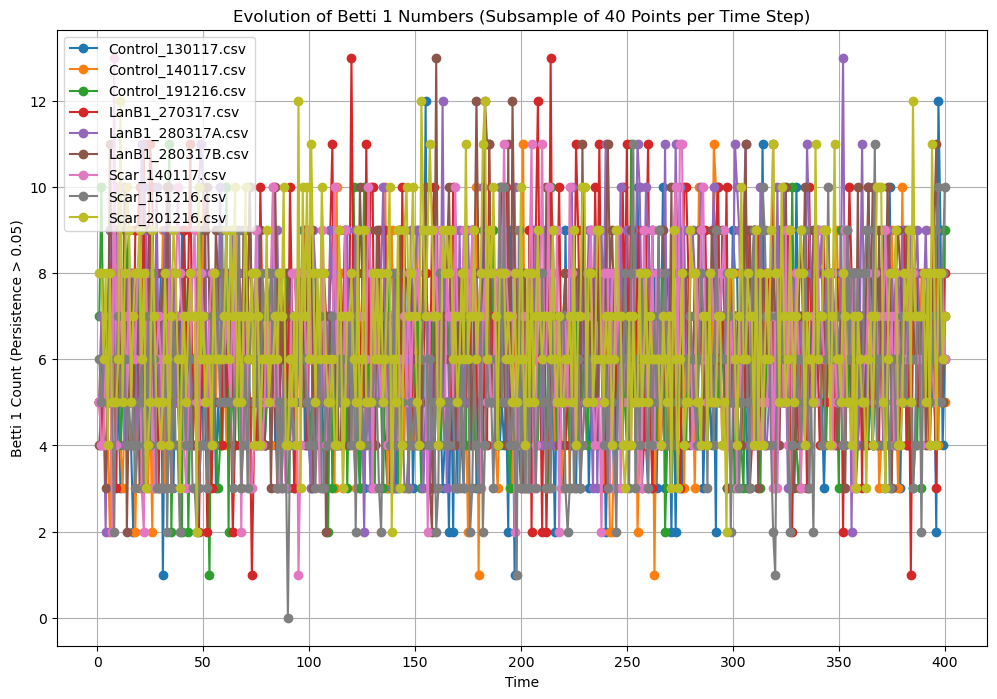

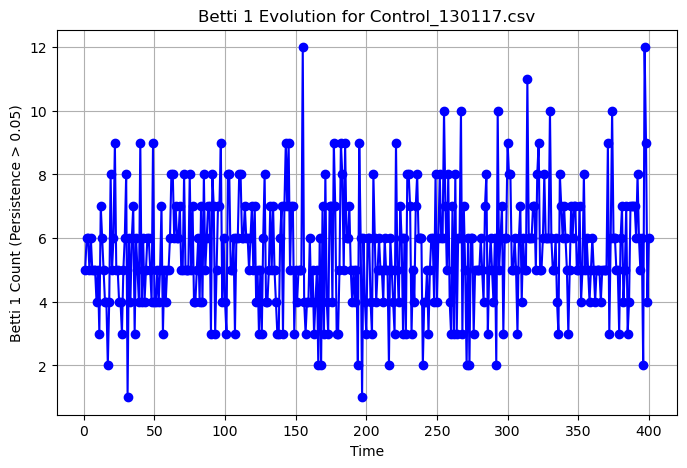

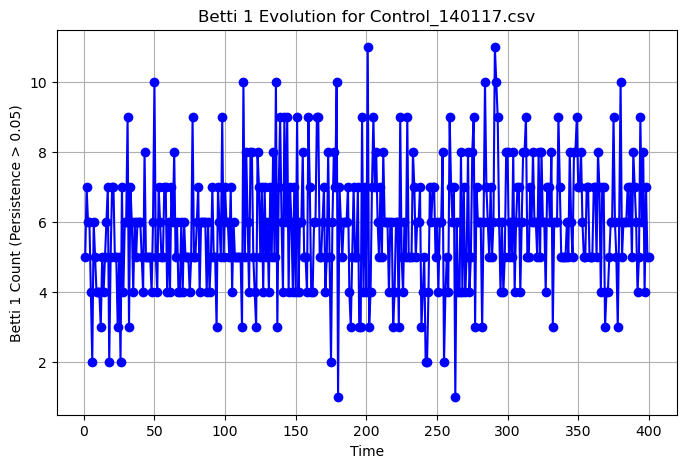

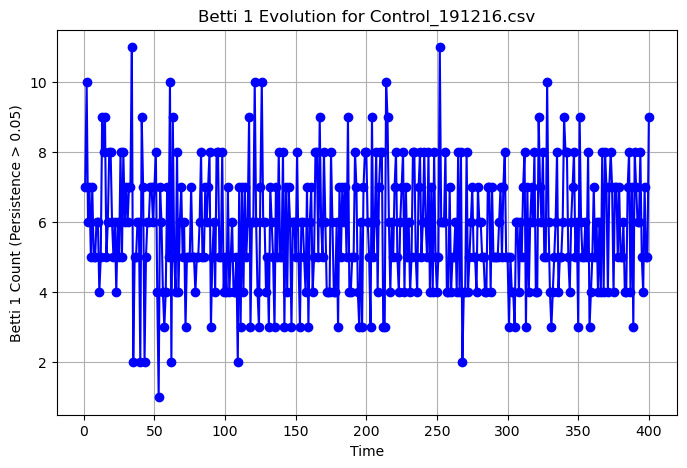

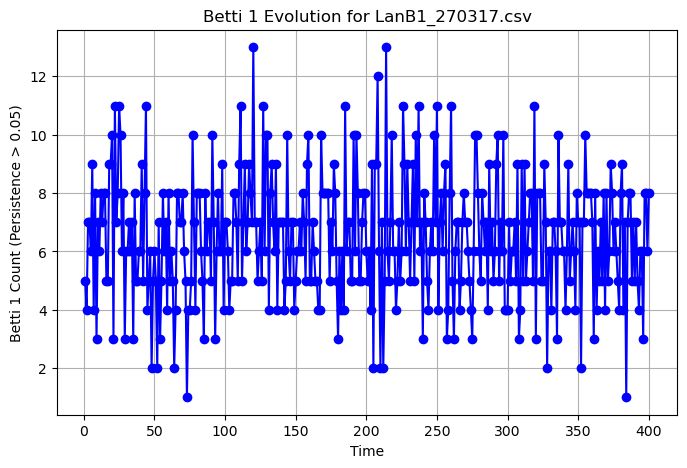

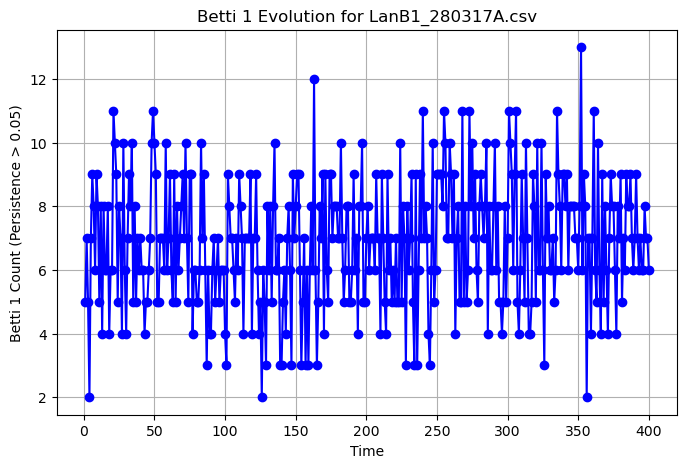

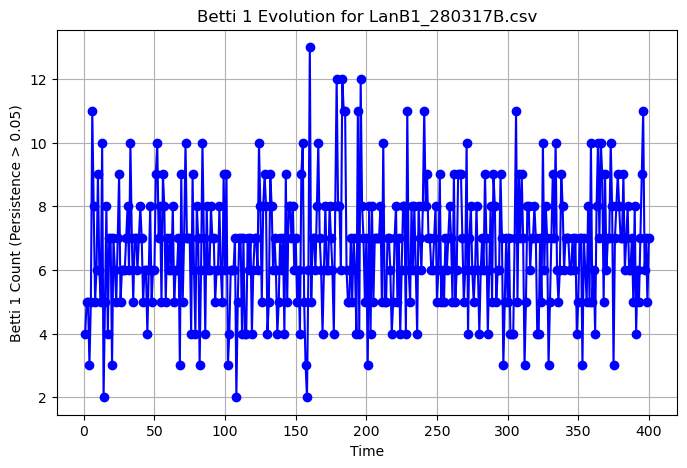

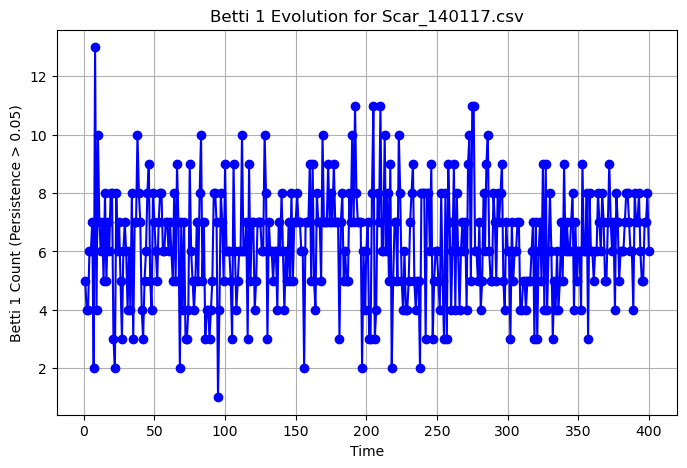

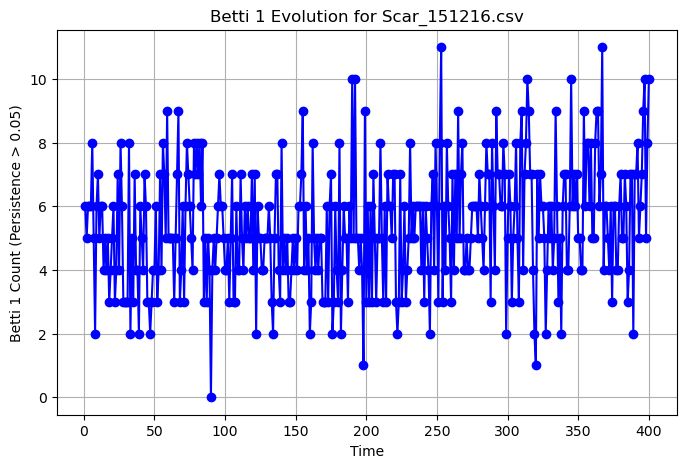

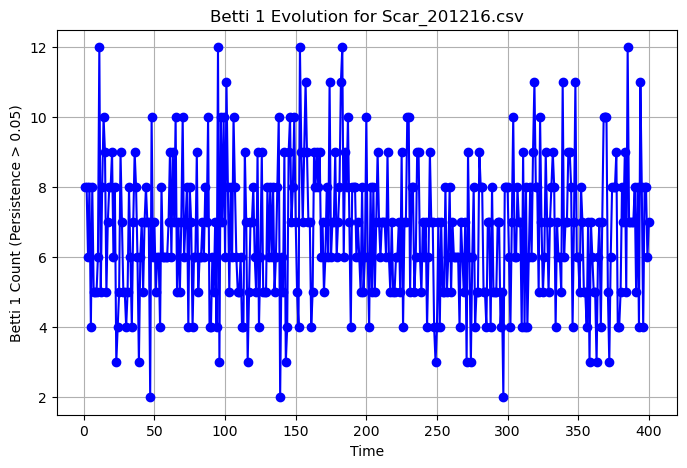

In [7]:
import pandas as pd
import numpy as np
from ripser import ripser
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parameters
PERSISTENCE_THRESHOLD = 0.05  # Minimum persistence to count a feature
SUBSAMPLE_SIZE = 40         # Number of points to sample at each time step

# Define file groups with corresponding file paths
files_by_group = {
    "Control": [
        "Control_130117.csv",
        "Control_140117.csv",
        "Control_191216.csv"
    ],
    "LanB1": [
        "LanB1_270317.csv",
        "LanB1_280317A.csv",
        "LanB1_280317B.csv"
    ],
    "SCAR": [
        "Scar_140117.csv",
        "Scar_151216.csv",
        "Scar_201216.csv"
    ]
}

# Dictionary to store Betti 1 results.
# Structure: betti1_results[file_path][time_step] = betti1_count
betti1_results = {}

# Loop over each file group and file
for group, file_list in files_by_group.items():
    for file_path in file_list:
        print(f"\nProcessing file: {file_path} (Group: {group})")
        data = pd.read_csv(file_path)
        # Get unique time steps (assuming the time column is named 'Time')
        times = sorted(data['Time'].unique())
        betti1_results[file_path] = {}
        
        # Process each time step with a progress bar
        for t in tqdm(times, desc=f"Processing time steps for {file_path}"):
            # Filter data for the current time step
            time_data = data[data['Time'] == t]
            coords = time_data[['Position X', 'Position Y', 'Position Z']].values
            
            # If there are fewer points than the subsample size, record 0 and continue.
            if len(coords) < SUBSAMPLE_SIZE:
                betti1_results[file_path][t] = 0
                continue
            
            # Randomly sample 40 points (without replacement)
            indices = np.random.choice(len(coords), SUBSAMPLE_SIZE, replace=False)
            subsample_coords = coords[indices]
            
            # Compute persistent homology (up to dimension 2)
            result = ripser(subsample_coords, maxdim=2)
            dgm1 = result['dgms'][1]  # H1 persistence diagram
            
            # Count features with persistence > threshold (skip infinite death)
            betti1_count = 0
            for birth, death in dgm1:
                if np.isinf(death):
                    continue
                if (death - birth) > PERSISTENCE_THRESHOLD:
                    betti1_count += 1
                    
            betti1_results[file_path][t] = betti1_count

# === Aggregated Plot for All Files ===
plt.figure(figsize=(12, 8))
for group, file_list in files_by_group.items():
    for file_path in file_list:
        times = sorted(betti1_results[file_path].keys())
        counts = [betti1_results[file_path][t] for t in times]
        plt.plot(times, counts, marker='o', linestyle='-', label=file_path)
plt.xlabel("Time")
plt.ylabel(f"Betti 1 Count (Persistence > {PERSISTENCE_THRESHOLD})")
plt.title("Evolution of Betti 1 Numbers (Subsample of 40 Points per Time Step)")
plt.legend()
plt.grid(True)
plt.show()

# === Individual Plots for Each File ===
for file_path, time_dict in betti1_results.items():
    times = sorted(time_dict.keys())
    counts = [time_dict[t] for t in times]
    
    plt.figure(figsize=(8, 5))
    plt.plot(times, counts, marker='o', linestyle='-', color='b')
    plt.xlabel("Time")
    plt.ylabel(f"Betti 1 Count (Persistence > {PERSISTENCE_THRESHOLD})")
    plt.title(f"Betti 1 Evolution for {file_path}")
    plt.grid(True)
    plt.show()
